In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

In [2]:
mnist
X, y = mnist["data"], mnist["target"]

(-0.5, 27.5, 27.5, -0.5)

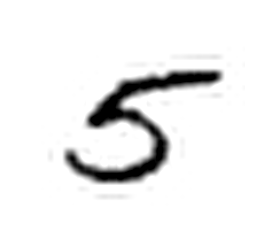

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36008]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="sinc")
plt.axis("off")

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
#Traning binary classifier for 5
y_train_5 = (y_train == 5.0)
y_test_5 = (y_test == 5.0)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [12]:
#Implementing Cross Validation by yourself
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state =42)
for train_index , test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96135
0.94675
0.87675


In [14]:
#implementing k Cross Validation from sklearn package
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.96135,  0.94675,  0.87675])

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

#Precision TP/(TP+FP)
#Recall or Sensitivity TP/(TP+FN)
#F1 Score 1/((1/Recall)+(1/Precision))

from sklearn.metrics import precision_score, recall_score
print("Precision Score:",precision_score(y_train_5, y_train_predict))
print("Recall Score:", recall_score(y_train_5, y_train_predict))

Precision Score 0.571392081737
Recall Score 0.825308983582


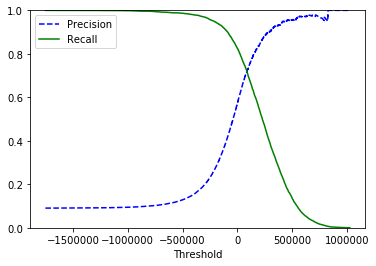

In [28]:
#Precision Recall Curves
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [30]:
precision_recall_curve(y_train_5, y_scores)

(array([ 0.09061884,  0.09060363,  0.09060515, ...,  1.        ,
         1.        ,  1.        ]),
 array([  1.00000000e+00,   9.99815532e-01,   9.99815532e-01, ...,
          3.68935621e-04,   1.84467810e-04,   0.00000000e+00]),
 array([-1751854.22992455, -1748920.65028651, -1748110.08194371, ...,
         1000708.77348231,  1015215.26356435,  1026372.13499156]))

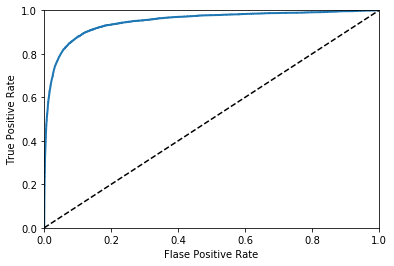

In [33]:
#ROC Curves
#Plots between TP Rate(Recall) vs FP Rate(1-Specificity(TN Rate))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth =2, label = label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1, 0,1])
    plt.xlabel('Flase Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9489682624009329